# Subpopulations Meta-Learning Distributions

In [1]:
from os import makedirs
from os.path import join

import pandas as pd

from common import ALIASES, filter_mset, plot_coocc, read_toml

In [2]:
config = read_toml('config.toml')
metachest_dir = config['metachest_dir']
df = pd.read_csv(join(metachest_dir, 'metachest.csv'))

mclasses = {'mtrn': config['mtrn'], 'mval': config['mval'], 'mtst': config['mtst']}
mset_dfs = [filter_mset(mset, mclasses, df)
            for mset in mclasses.keys()]

In [3]:
def age_mask(df, val):
    if val == 'center':
        a_left, a_right = [31, 62]
        mask = df['age'].between(a_left, a_right, inclusive='both')
    else:
        (a_left, a_right), (b_left, b_right) = [10, 30], [63, 80]
        mask = (df['age'].between(a_left, a_right, inclusive='both')|
                df['age'].between(b_left, b_right, inclusive='both'))
    return mask


def sex_mask(df, val):
    return df['sex'] == val[:1]


def view_mask(df, val):
    return df['view'] == val


subpops = [
    # name      val         mask
    ['age',     'center',   age_mask],
    ['age',     'tails',    age_mask],
    ['sex',     'female',   sex_mask],
    ['sex',     'male',     sex_mask],
    ['view',    'ap',       view_mask],
    ['view',    'pa',       view_mask]
]

distro_dir = join(metachest_dir, 'distro')
makedirs(distro_dir, exist_ok=True)

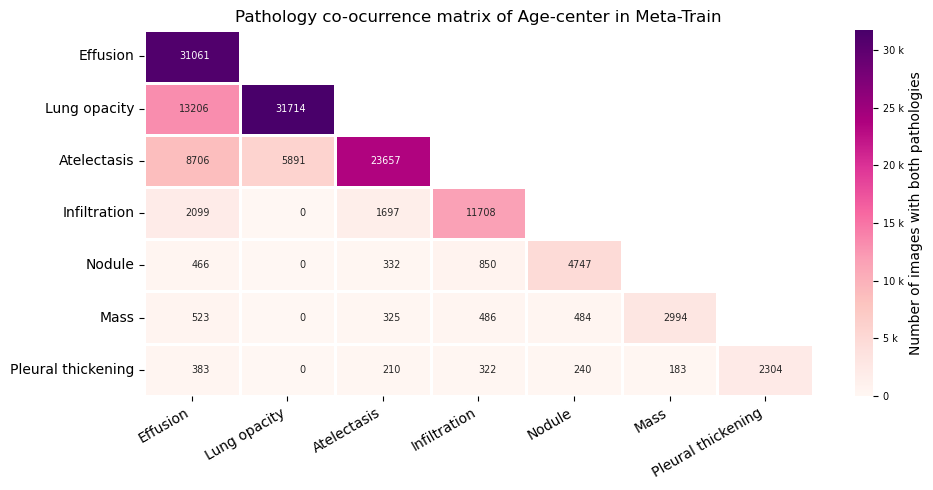

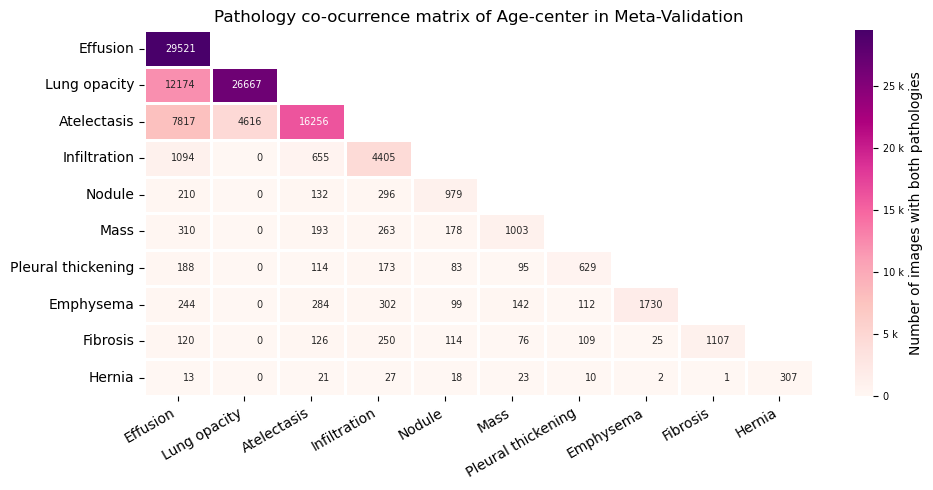

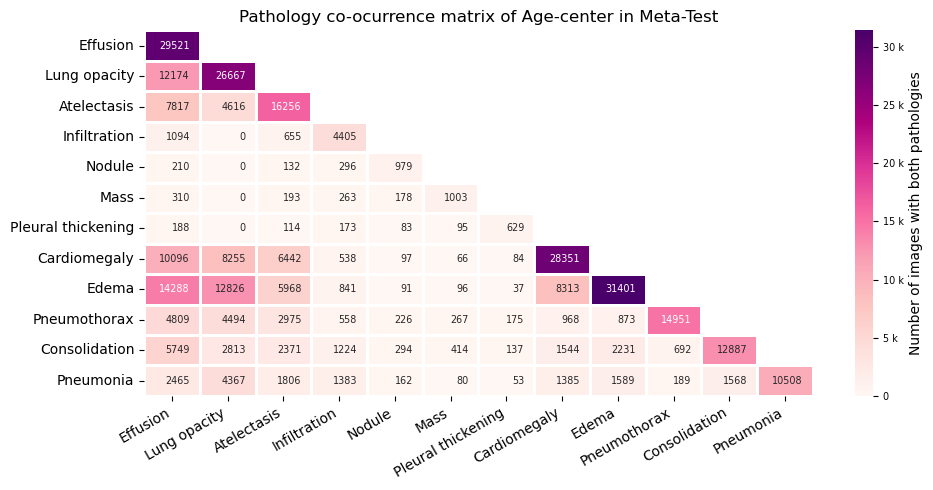

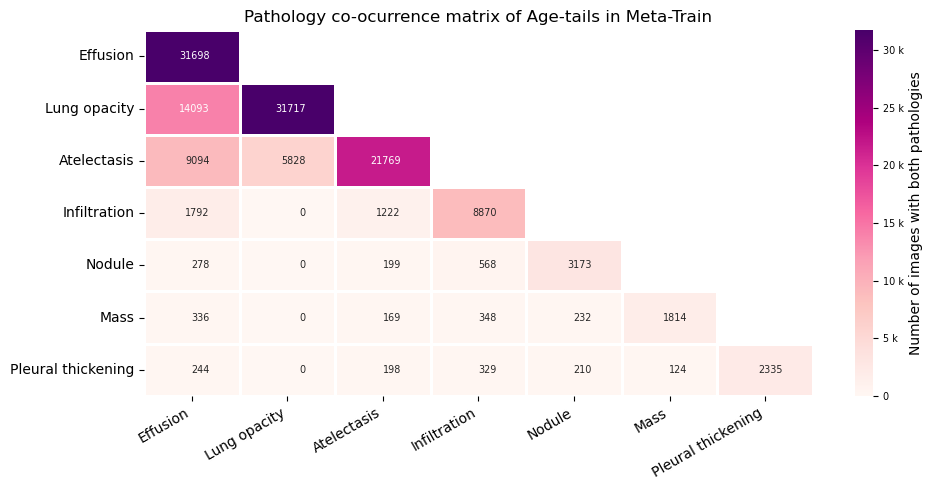

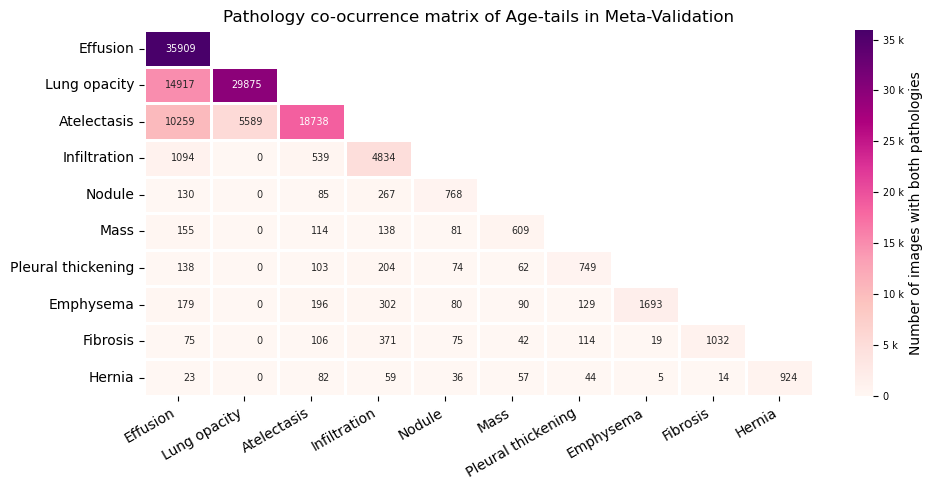

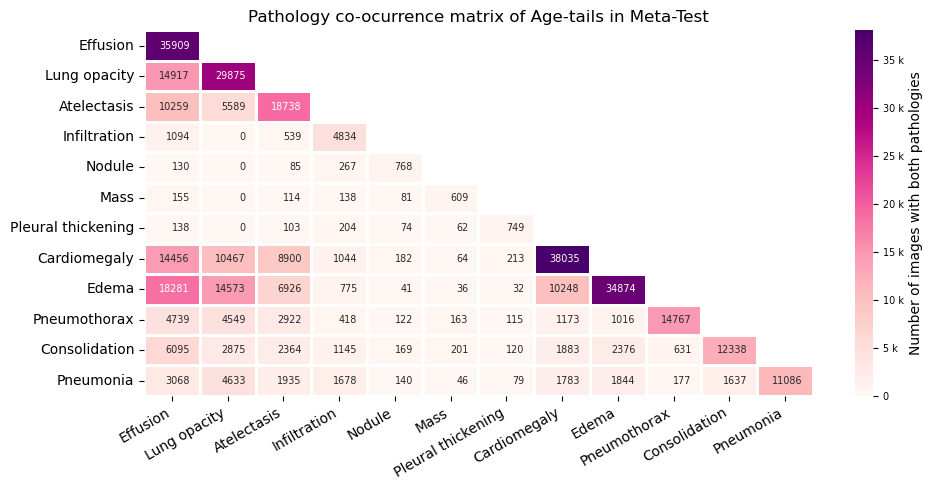

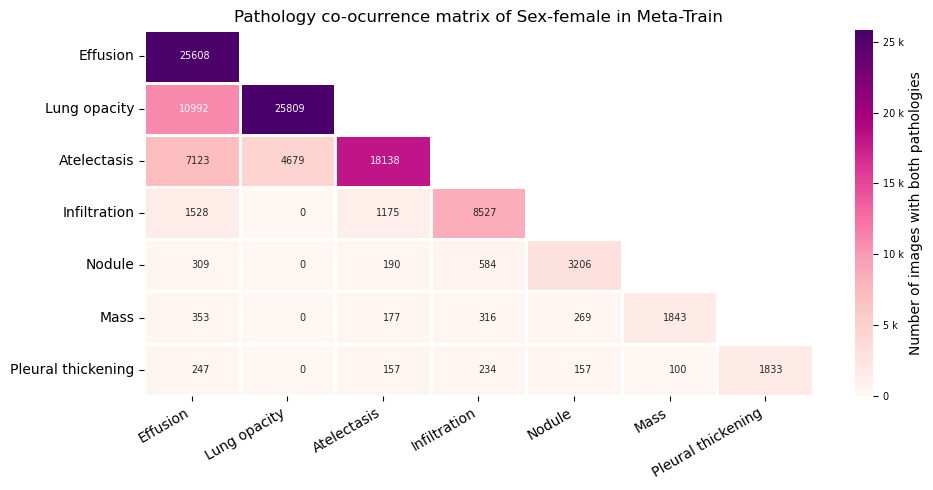

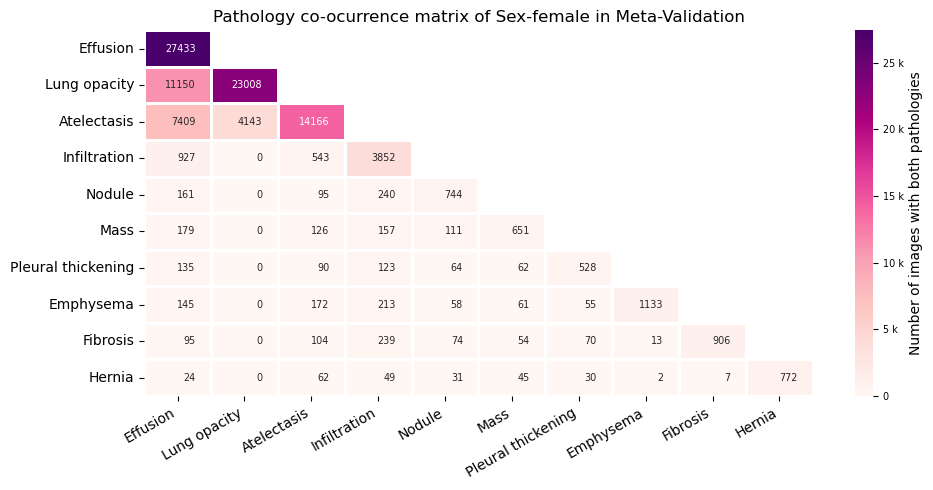

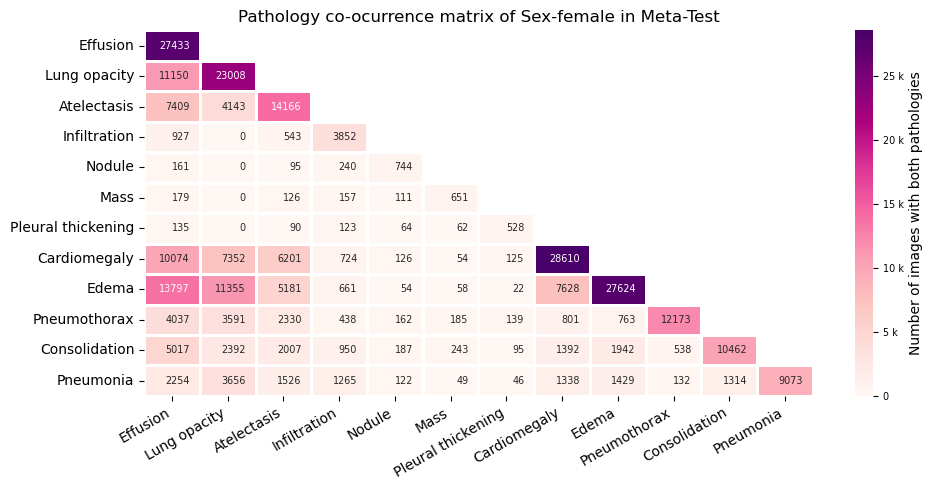

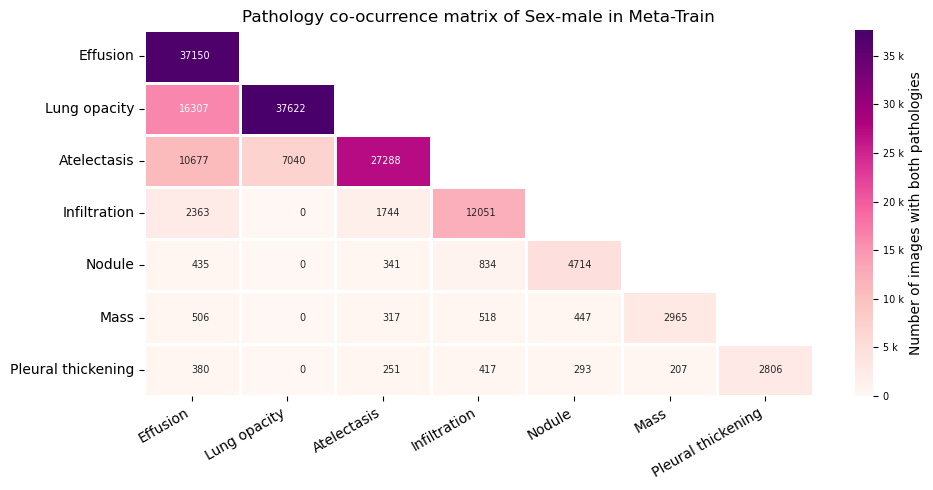

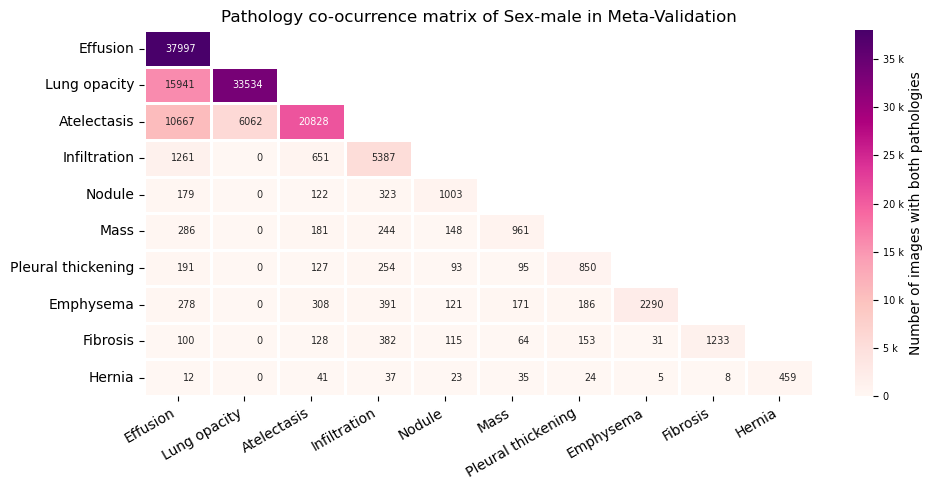

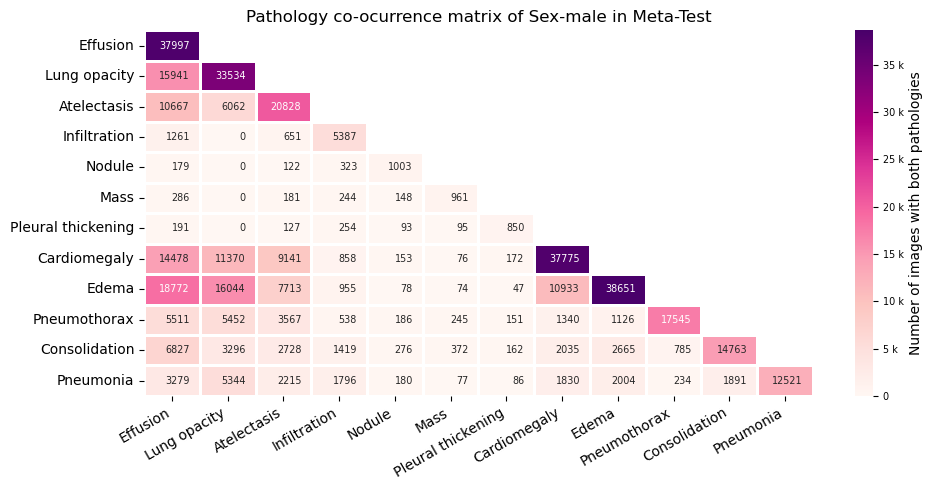

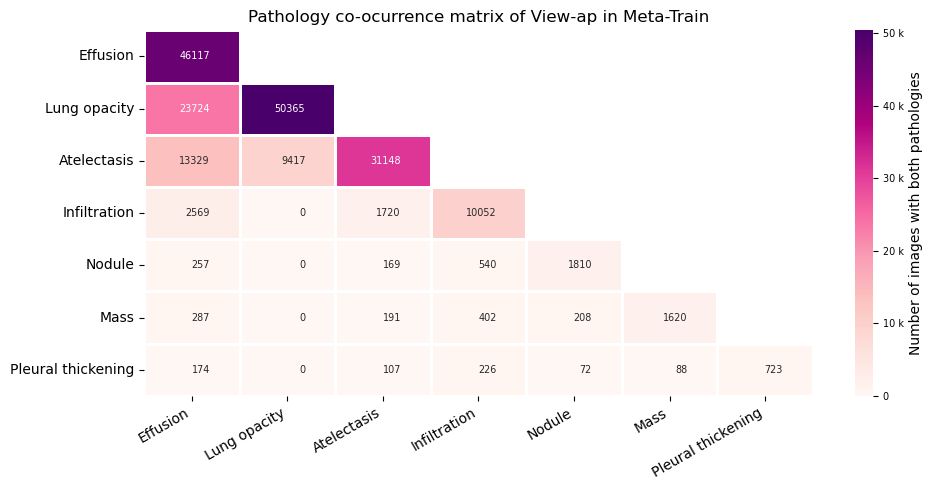

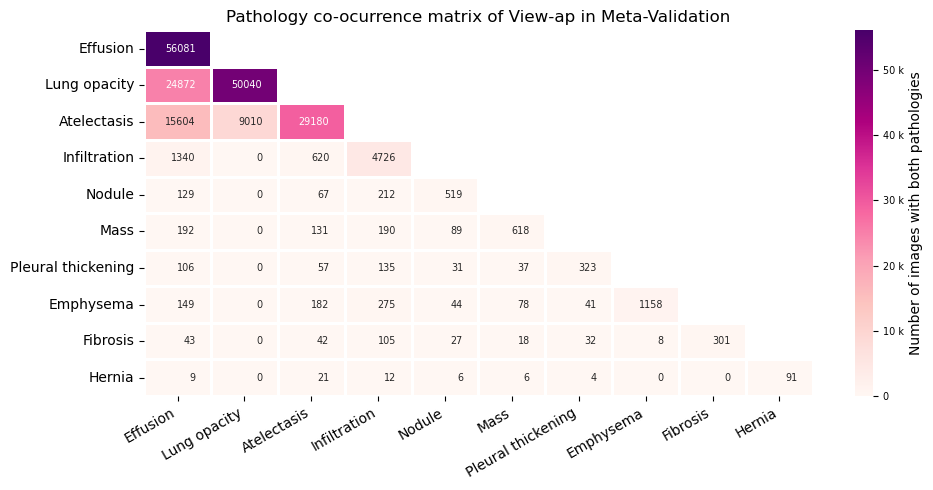

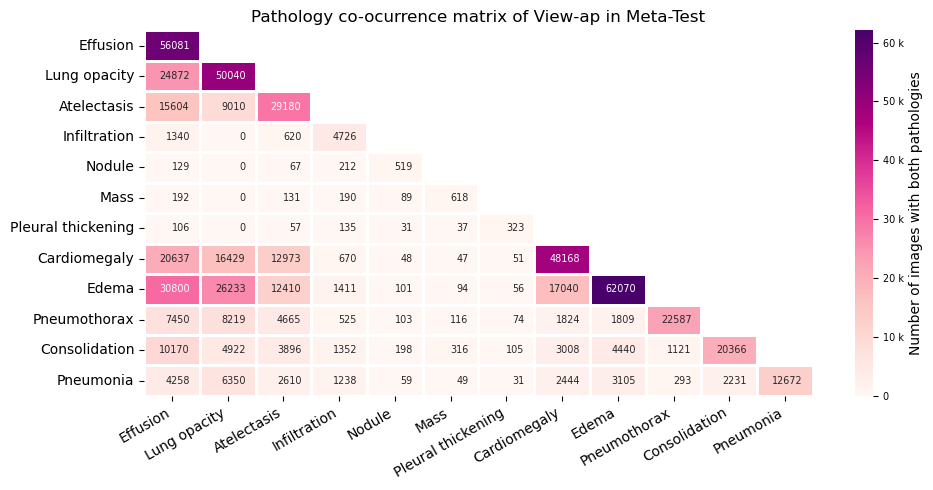

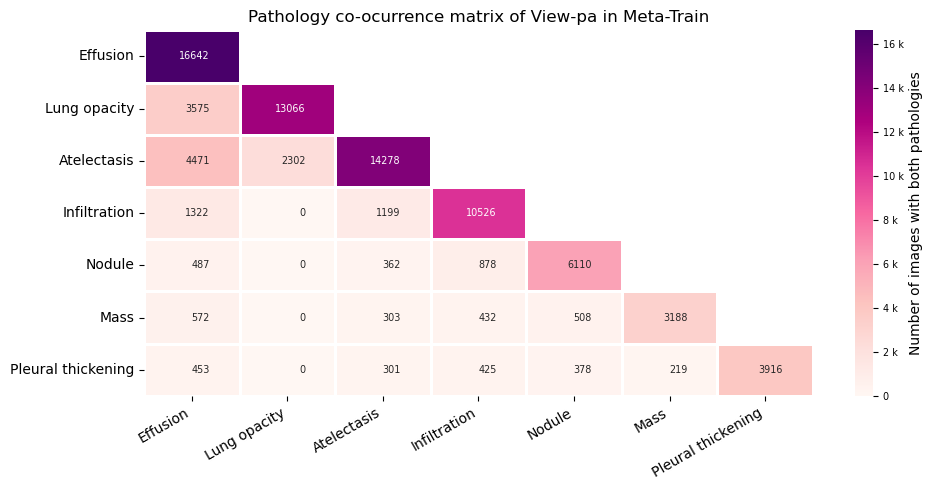

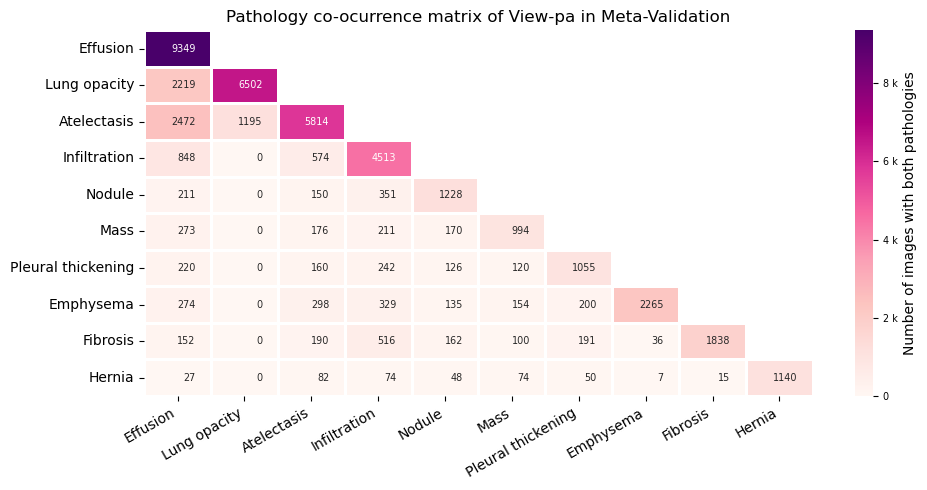

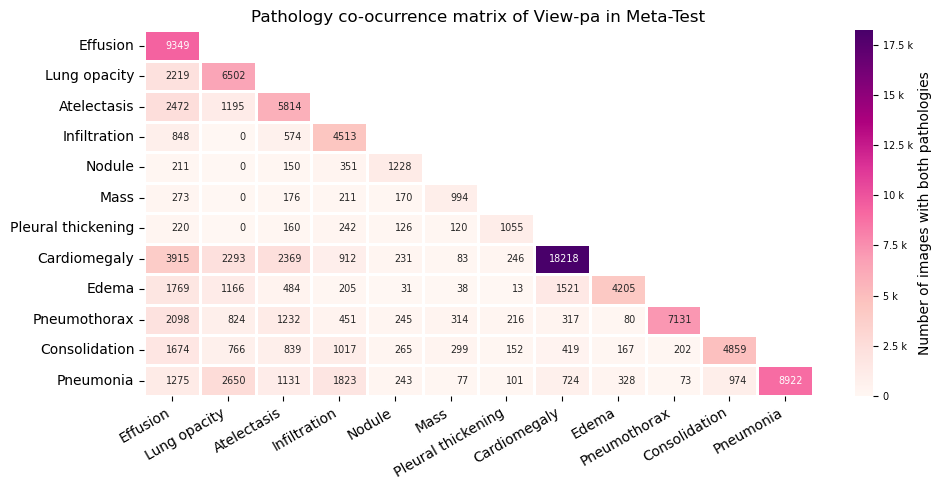

In [4]:
for name, val, fn_mask in subpops:
    mask = fn_mask(df, val)
    mask = mask.rename('mask')
    path = join(distro_dir, f'{name}_{val}.csv')
    mask.astype(int).to_csv(path, index=False)
    dataset_title = f'{ALIASES[name]}-{val}'
    for mset, mset_df in zip(mclasses.keys(), mset_dfs):
        ds_mset_df = mset_df.loc[mask]
        plot_coocc(dataset_title, mset, ds_mset_df.iloc[:, 5:])